# DGA DETECTION MODEL

In [70]:
# IMPORT MODULES

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Data Ingestion

In [71]:
# READ Clean Domains
data_clean = pd.read_csv('Alexa_CleanDomains.csv',header=None)
data_clean['domains']=data_clean[0]


# READ DGA Domains
data_dga = pd.read_csv('DGADomains.csv',header=None)
data_dga['domains']=data_dga[0]

data_dga.sample(5)


,0,domains
47125,wdnglqepcvqgd,wdnglqepcvqgd
24129,jnrajjtytbtk,jnrajjtytbtk
16003,fbuqcjjrzkjgmvcqpamztnra,fbuqcjjrzkjgmvcqpamztnra
27356,lhyumjltydrsp,lhyumjltydrsp
32109,ny0pkvviyi171mkulddml3fpt,ny0pkvviyi171mkulddml3fpt


 # Data Prep

In [72]:
# Clean Data without Index
train_clean = pd.DataFrame(data_clean['domains'])
train_clean.sample(4)


,domains
829136,omonilelawyer
828865,droolcup
500786,pandoon
727277,wordpress


In [73]:
clean_dom = train_clean[[0]] # 0 are clean

clean_domains = clean_dom.values
#clean_domains=clean_domains1.tolist()
clean_domains_flat = [val for sublist in clean_domains for val in sublist]
#clean_domains_flat

In [74]:
# Clean Data without Index

df_dga = pd.DataFrame(data_dga['domains'])
train_dga = df_dga

dga_dom = train_dga[[0]]
dga_domains = dga_dom.values
dga_domains_flat = [val for sublist in dga_domains for val in sublist]
# dga_domains_flat


# FEATURE EXTRACTION

# FEATURE 1 : Domain Entropy 

In [75]:
# Shannon entropy H of a given input string.
# Given the discreet random variable X that is a string of N "symbols" consisting of n different characters (n=2 for binary), 
# the Shannon entropy of X in bits/symbol is : where count is the count of character n.

import math
from collections import Counter

def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [76]:
# Entropy of clean dataset
entropy_clean = []

for l in clean_domains_flat:
    entropy_clean.append(entropy(str(l)))

# Check the Entropy Values
#entropy_clean

In [77]:
# Entropy of dga dataset
entropy_dga = []
for ll in dga_domains_flat:
    entropy_dga.append(entropy(ll))

# Check the Entropy Values
#entropy_dga

In [78]:
print(np.mean(entropy_clean))
print(np.mean(entropy_dga))

2.7729247366
3.53054001114


In [79]:
clean_dom['label'] = "0"
dga_dom['label'] = "1"

# Add entropy calculations to dataframes
clean_dom['entropy'] = entropy_clean
dga_dom['entropy'] = entropy_dga

dga_dom.sample(5)

,domains,label,entropy
26579,kxyopcewejxtnma,1,3.640224
15602,ewkovrirsprw,1,3.022055
37501,qvvycgguufmu,1,2.855389
5861,3gmway1oa6fh1tsyauyj60o03,1,3.863465
38927,rqfrbcvjjdpcau,1,3.378783


# FEATURE 2 : Domain Length

In [80]:
# lexical study
def dom_length(s):
    
    return len(s)

In [81]:
len_clean = []
for ll in clean_domains_flat:
    len_clean.append(dom_length(str(ll)))

In [82]:
len_dga = []
for ll in dga_domains_flat:
    len_dga.append(dom_length(ll))

In [83]:
# Length
clean_dom['length'] = len_clean
dga_dom['length'] = len_dga

In [84]:
print(np.mean(len_clean))
print(np.mean(len_dga))

10.0062963686
17.7261834685


# FEATURE 3 : Vowel ratio

In [85]:
vowels = list("aeiou")
consonants = list("bcdfghjklmnpqrstvxzy")

In [86]:
# Feature Consonant/length
def conlen_ratio(s):
    number_of_vowels = sum(str(s).count(c) for c in vowels)
    ratio= float(number_of_vowels)/len(s)
    return ratio

In [87]:
# Clean data
cl_ratio_clean = []
for ll in clean_domains_flat:
    cl_ratio_clean.append(conlen_ratio(str(ll)))

In [88]:
# Clean data
cl_ratio_dga = []
for ll in dga_domains_flat:
    cl_ratio_dga.append(conlen_ratio(ll))
    

In [89]:
clean_dom.head()

,domains,label,entropy,length
0,google,0,1.918296,6
1,youtube,0,2.521641,7
2,facebook,0,2.750000,8
3,baidu,0,2.321928,5
4,yahoo,0,1.921928,5


In [90]:
print(np.mean(cl_ratio_clean))
print(np.mean(cl_ratio_dga))

0.358365814794
0.182585978075


In [91]:
# Add ratio calculations to dataframes
clean_dom['ratio'] = cl_ratio_clean
dga_dom['ratio'] = cl_ratio_dga

# FEATURE 4 : Distinct Characters/length

In [129]:
0# Feature 4 : Distinct Character
def dom_distchar(s):
 dist_char = ''.join(set(s)) 
 
 return len(dist_char)/len(s)

In [135]:
#print dom_distchar('testing')

In [134]:
# Clean
dist_clean = []
for ll in clean_domains_flat:
    dist_clean.append(dom_distchar(str(ll)))
    
dist_dirty = []
for ll in dga_domains_flat:
    dist_dirty.append(dom_distchar(str(ll)))    

#dist_clean

In [94]:
print(np.mean(dist_clean))
print(np.mean(dist_dirty))

0.213067991375
0.0134249852838


In [95]:
# Add ratio calculations to dataframes
clean_dom['diff_char'] = dist_clean
dga_dom['diff_char'] = dist_dirty
print(len(clean_dom))

999465


In [96]:
feature_dataset =  pd.concat([clean_dom, dga_dom], ignore_index=True)


# FEATURE 5: PercentageCoverage


In [97]:
import nltk
#nltk.download()
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [98]:
def getPercentageCoverage(s):
    count = 0
    tcount = 0
    for i in range(0,len(s)):
        for j in range(i,len(s)):
            if s[i:j+1] in english_vocab:
                tcount += 1
            count += 1
    return tcount / float(count) 

In [99]:
feature_dataset["pctCoverage"] = feature_dataset["domains"].apply(lambda x: getPercentageCoverage(str(x)))


In [100]:
# FEATURE: NUMBER OF DIGITS PER UNIT LENGTH IN EACH DOMAIN
def num_digits(s):
   o = sum(c.isdigit() for c in s)
   return o

feature_dataset["digits"] = feature_dataset["domains"].apply(lambda x: num_digits(str(x))/len(str(x)))

In [101]:
char_set = "abcdefghijklmnopqrstuvwxyz-"
for ch in char_set:
    feature_dataset[ch] = feature_dataset["domains"].apply(lambda x: float(str(x).count(ch))/len(str(x)))

In [102]:
print(feature_dataset[:10])

     domains label   entropy  length     ratio  diff_char  pctCoverage  \
0     google     0  1.918296       6  0.500000          0     0.476190   
1    youtube     0  2.521641       7  0.571429          0     0.571429   
2   facebook     0  2.750000       8  0.500000          0     0.444444   
3      baidu     0  2.321928       5  0.600000          1     0.600000   
4      yahoo     0  1.921928       5  0.600000          0     0.733333   
5     amazon     0  2.251629       6  0.500000          0     0.666667   
6  wikipedia     0  2.641604       9  0.555556          0     0.333333   
7         qq     0 -0.000000       2  0.000000          0     0.666667   
8     google     0  1.918296       6  0.500000          0     0.476190   
9    twitter     0  2.128085       7  0.285714          0     0.571429   

   digits         a         b ...          r    s         t         u    v  \
0       0  0.000000  0.000000 ...   0.000000  0.0  0.000000  0.000000  0.0   
1       0  0.000000  0.142857

# DUMP DGA MODEL FEATURE DATA AS A .CSV FILE

In [103]:
# Output 
#with open('C:\\Users\\xoc201\\Documents\\Correlation\\feature_dataset.csv','a') as dd:
    #feature_dataset.to_csv(dd, index=False)

# Random Forest Model

In [136]:
msk = np.random.rand(len(feature_dataset)) < 0.75

train = feature_dataset[msk]

test = feature_dataset[~msk]

from sklearn.ensemble import RandomForestClassifier
features = feature_dataset.columns[2:45]

In [137]:
clf = RandomForestClassifier(n_jobs=30)
y, _ = pd.factorize(train['label'])

In [138]:
clf.fit(train[features], y)
predicted = clf.predict(test[features])
print(features)

Index([u'entropy', u'length', u'ratio', u'diff_char', u'pctCoverage',
       u'digits', u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j',
       u'k', u'l', u'm', u'n', u'o', u'p', u'q', u'r', u's', u't', u'u', u'v',
       u'w', u'x', u'y', u'z', u'-'],
      dtype='object')


In [107]:
y_test, _ = pd.factorize(test['label'])
print(metrics.confusion_matrix(y_test, predicted))

[[298927    256]
 [  1108  14492]]


In [108]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    299183
          1       0.98      0.93      0.96     15600

avg / total       1.00      1.00      1.00    314783



In [109]:
print(metrics.accuracy_score(y_test, predicted))

0.995666856215


# Feature Importance

In [110]:
clf.feature_importances_

# Feature List
# 'entropy', 'length', 'ratio', 'diff_char', 'pctCoverage', 'a', 'b', 'c',
#       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
#       'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'digits'

array([  9.51385859e-02,   1.31846887e-01,   8.40606431e-02,
         1.61071050e-03,   2.36314521e-01,   2.31383532e-06,
         1.31145322e-02,   8.44698825e-03,   3.90626956e-03,
         4.53100598e-03,   4.00264631e-02,   2.18235120e-02,
         6.24786117e-03,   5.57467589e-03,   9.11934899e-03,
         3.91044289e-02,   6.39955097e-03,   4.27600189e-03,
         5.55108071e-03,   6.84196201e-03,   7.20416649e-03,
         5.14314074e-03,   8.00637788e-02,   5.91490493e-03,
         6.27532788e-03,   4.09792038e-03,   8.32147783e-03,
         2.39819827e-02,   2.02412923e-02,   5.40864587e-02,
         1.21798178e-02,   2.79734959e-03,   4.57550386e-02])

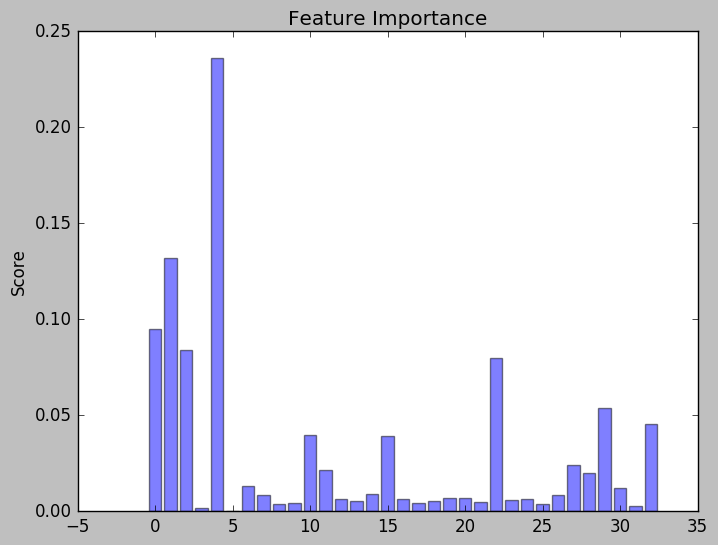

In [111]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


objects = clf.feature_importances_
y_pos = np.arange(len(objects))
 
b1 = plt.bar(y_pos, objects, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)

plt.ylabel('Score')
plt.title('Feature Importance')

plt.show()

# Feature List from feature 0 (=Entropy) to feature 31 
# 'entropy', 'length', 'ratio', 'diff_char', 'pctCoverage', 'a', 'b', 'c',
#       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
#       'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'digits'